https://wikidocs.net/72820 참고_영어 요약

In [1]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaconda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import numpy as np

In [3]:
# Reviews.csv 의 샘플 수는 56만 개. 너무 많으니 샘플 수를 제한.
data = pd.read_csv("C:/Users/anaconda/python/club/Reviews.csv", nrows = 5000)
print("전체 샘플 수 :", len(data))

전체 샘플 수 : 5000


In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data = data[['Text', 'Summary']]  # 전체 데이터 중 Text 열과 Summary 열만 별도로 저장
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [6]:
data.sample(15)  # 데이터 샘플 출력

,Text,Summary
3408,Funny thing - I bought some of these K-cups se...,Pretty good - not as bad as others are saying.
1893,I have subscribed these chips. They are so tas...,Love it! so tasty!
1258,We found this on our recent trip to England an...,Delicious! Best custard ever!
3764,This is the best Sweet Chili sauce I have foun...,This is the stuff you want.
4337,I love that it is mainstream and that it works...,Works like Bisquick
2188,"Using the entire sauce packet is over kill, le...",Satay Noodles
1385,I bought the NuNaturals White Stevia with Malt...,Tastes great in iced drinks
908,This is my son's favorite dinner! Best of all ...,Sons Favorite Dinner!!!
664,I am so glad I was introduced the this brand o...,My Go to sweetner
1915,I have had the herb pods for about 6 months. ...,"Great concept, poor product"


데이터 전처리 하기

In [7]:
# 중복과 같은 방해가 되는 샘플 제거
print("Text 열에서 중복을 배제한 유일한 샘플의 수: ", data['Text'].nunique())
print("Summary 열에서 중복을 배제한 유일한 샘플의 수: ", data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수:  4984
Summary 열에서 중복을 배제한 유일한 샘플의 수:  4566


In [8]:
# 중복 샘플 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플 수: ", len(data))

전체 샘플 수:  4984


In [9]:
data.isnull().sum()    # 데이터 프레임에 Null(:None) 값이 있는지 확인

Text       0
Summary    0
dtype: int64

In [10]:
data.dropna(axis=0, inplace=True)  # 데이터 프레임에서 Null 값 제거
print("전체 샘플 수:", len(data))

전체 샘플 수: 4984


In [11]:
# 텍스트 정규화: 같은 의미인데도 다른 단어로 인식되지 않게 같은 표현으로 통일하는 것
# ex) it'll = it will, we're = we are 등...
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [12]:
# 불용어: 텍스트에 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어
print("불용어의 개수 : ", len(stopwords.words('english')))
print(stopwords.words('english'))
# NLTK에서 미리 정의하여 제공하고 있는 불용어 불러오기.

불용어의 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [14]:
# 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [15]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 오래걸림
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))  # 너무 안 돌아가서 50000개로 줄임.
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [16]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 오래걸림
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [17]:
# 전처리 후의 결과를 다시 데이터 프레임에 저장
data['Text'] = clean_text
data['Summary'] = clean_summary

In [18]:
# 공백이 생겼다면 null 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text       0
Summary    3
dtype: int64


In [19]:
# null 값을 가지는 샘플을 제거한 뒤 전체 샘플 수 확인.
data.dropna(axis = 0, inplace = True)
print('전체 샘플 수 : ',(len(data)))

전체 샘플 수 :  4981


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 449
텍스트의 평균 길이 : 35.75025095362377
요약의 최소 길이 : 1
요약의 최대 길이 : 22
요약의 평균 길이 : 3.9184902629993976


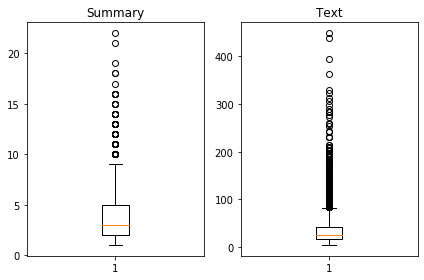

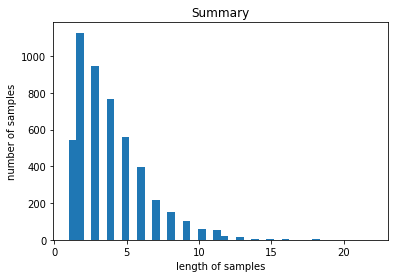

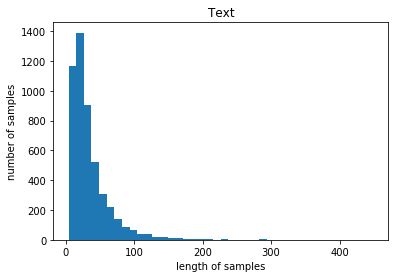

In [20]:
# 길이 분포 확인.
# 각 텍스트를 공백을 기준으로 쪼갠 다음에 길이 확인. 즉, 단어의 개수
text_len = [len(s.split()) for s in data['Text']] 
summary_len = [len(s.split()) for s in data['Summary']] 

# {} 안에 fotmat()안의 인자가 들어간다.
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))


# 그래프로 표현하기
plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

패딩: 데이터에 특정 값을 채워서 데이터의 크기를 조정.
패딩의 값을 정하는 것은 컴퓨터가 길이가 같은 문서들을 한꺼번에 묶어서 처리할 수 있기 때문임. 
패딩의 길이를 정하고 그것보다 큰 길이의 문서는 제거, 그것보다 작은 길이의 문서에는 실제 의미가 없는 0번 단어(컴퓨터가 무시함)을 채워 데이터 크기를 조정한다.

In [21]:
text_max_len = 45
summary_max_len = 6

In [22]:
# 패딩 길이가 샘플들의 길이와 얼마나 차이가 나는지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [23]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.7723348725155591


In [24]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 6 이하인 샘플의 비율: 0.8711102188315599


In [25]:
# 패딩 길이보다 큰 길이의 샘플 삭제 후 남은 샘플 수 확인
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))
data.head()

전체 샘플수 : 3478


,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [26]:
# seq2seq 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 앞뒤에 추가.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [27]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

데이터 분리(훈련용과 테스트용)

In [28]:
# 순서가 섞인 정수 시퀀스
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[3427 2483 2254 ... 1205  845  521]


In [29]:
# 순서가 섞인 시퀀스를 데이터의 샘플 순서로 정의 > 샘플의 순서가 섞인다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [30]:
# 20%를 테스트 데이터로 분류
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 695


In [31]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [32]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 2783
훈련 레이블의 개수 : 2783
테스트 데이터의 개수 : 695
테스트 레이블의 개수 : 695


In [33]:
# 텍스트를 숫자로 처리할 수 있게 데이터에 정수 인코딩 수행, 단어 집합 생성.
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [34]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7055
등장 빈도가 6번 이하인 희귀 단어의 수: 5607
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1448
단어 집합에서 희귀 단어의 비율: 79.47554925584693
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.751358261425374


In [35]:
# 단어 집합의 수를 제한해 정수 인코딩 실행.
src_vocab = 1400
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [36]:
# 정수 인코딩이 제대로 되었는지 확인
print(encoder_input_train[:3])

[[34, 16, 738, 1065, 110, 132, 270, 1297, 247, 4, 13, 80, 738, 129, 9, 29, 57, 216, 9, 35], [551, 1, 17, 8, 395, 208, 628, 395, 442, 495, 15, 1167, 47, 3, 2, 270, 415, 739, 25, 176], [1168, 12, 24, 4, 209, 132, 92, 42, 213, 700, 1298, 24, 824, 991]]


In [37]:
# 레이블에 해당하는 데이터도 요약
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1810
등장 빈도가 5번 이하인 희귀 단어의 수: 1573
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 237
단어 집합에서 희귀 단어의 비율: 86.9060773480663
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 23.119801804990267


In [39]:
tar_vocab = 200
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [41]:
print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 49, 7, 19], [1, 50, 38, 5, 4], [1, 5, 6, 37, 17, 113, 179], [1, 8, 38, 70, 30, 60], [1, 154, 155, 114]]
[[49, 7, 19, 2], [50, 38, 5, 4, 2], [5, 6, 37, 17, 113, 179, 2], [8, 38, 70, 30, 60, 2], [154, 155, 114, 2]]


In [42]:
# 빈 샘플 제거. 길이가 0이 된 요약문의 실질적 길이는 모든 요약문에 추가된 토큰에 의해 1.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 341
삭제할 테스트 데이터의 개수 : 89


In [43]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 2442
훈련 레이블의 개수 : 2442
테스트 데이터의 개수 : 606
테스트 레이블의 개수 : 606


C:\Users\anaconda\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [44]:
# 패딩 작업

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

요약 모델 설계 및 훈련

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [47]:
# 디코더. 출력층 제외하고 설계. 인코더와 동일하지만 초기 상태를 인코더의 상태로 주어야 한다.
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [48]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      179200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

어텐션 메커니즘 사용. 깃허브에 올라온 파일을 다운로드 해 AttentionLayer를 import 함.

In [49]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [50]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      179200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [51]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [52]:
# 조기 종료 조건 설정 후 모델 학습.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
10/10 [==============================] - 50s 4s/step - loss: 4.0670 - val_loss: 2.4159
Epoch 2/50
10/10 [==============================] - 48s 5s/step - loss: 2.3955 - val_loss: 2.3092
Epoch 3/50
10/10 [==============================] - 58s 6s/step - loss: 2.2834 - val_loss: 2.2214
Epoch 4/50
10/10 [==============================] - 68s 7s/step - loss: 2.1826 - val_loss: 2.1278
Epoch 5/50
10/10 [==============================] - 75s 7s/step - loss: 2.0828 - val_loss: 2.1201
Epoch 6/50
10/10 [==============================] - 75s 8s/step - loss: 2.0747 - val_loss: 2.0387
Epoch 7/50
10/10 [==============================] - 79s 8s/step - loss: 1.9968 - val_loss: 2.0342
Epoch 8/50
10/10 [==============================] - 82s 8s/step - loss: 1.9898 - val_loss: 2.0036
Epoch 9/50
10/10 [==============================] - 83s 8s/step - loss: 1.9432 - val_loss: 1.9897
Epoch 10/50
10/10 [==============================] - 88s 9s/step - loss: 1.9277 - val_loss: 1.9903
Epoch 11/50
10/10 [

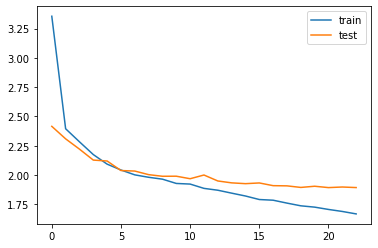

In [53]:
# 학습 과정 중 기록된 데이터의 손실 히스토리를 시각화하여 출력
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

테스트

In [54]:
# 테스트를 위한 사전 3개.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [55]:
# 인코더 설계. 훈련과 테스트 단계의 동작이 다르므로 모델 다시 설계 필요.
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [56]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [57]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [58]:
# 테스트를 위해 사용되는 함수 설계
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [60]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  seller nice price good reason stop went sugar free time watch fat take would get product 
실제 요약문 : coffee 
예측 요약문 :  great for


원문 :  good corn product eating case corn way expected well packed stores pantry nicely 
실제 요약문 : yummy 
예측 요약문 :  great


원문 :  favorite nut snacks absolute favorite almond really great given everyone ask buy great 
실제 요약문 : best way to eat 
예측 요약문 :  great


원문 :  beef sticks honey great combination beef sticks full flavor adding honey gives little sweetness top honey always favorite friends pack perfect take along 
실제 요약문 : sweet 
예측 요약문 :  great pancakes


원문 :  three small dogs one favorite treats worry feel giving healthy treat please ever stop making pet shape 
실제 요약문 : great for little dogs 
예측 요약문 :  great dog food


원문 :  like find bottle convenient like taste would definitely buy considering healthy use sure 
실제 요약문 : salt 
예측 요약문 :  great


원문 :  expected maybe tasteless really good tried bbq far packs lot flavor get lot chips single serving 

예측 요약문 :  great


원문 :  main ingredients dog food much better ingredients grocery store brands less expensive brands dog coat looks seems much healthier since switched food year ago nice thing target brand ever find end bag ordered time stop target 
실제 요약문 : very good 
예측 요약문 :  great dog food


원문 :  around amazon looking pleased see favorite sauce order shipped friends favorite love heat also love pineapple go wrong ordering 
실제 요약문 : best sauce 
예측 요약문 :  great


원문 :  bought husband drinking espresso life trip italy bought espresso able find order amazon bought gevalia try something new based reviews thought might good idea husband loves actually bought another pack use top fine type maker highly recommend 
실제 요약문 : wow 
예측 요약문 :  my


원문 :  purchased present come little white bags flavor someone gift would even know unless 
실제 요약문 : not as 
예측 요약문 :  great


원문 :  product described shipped promptly part diet bread 
실제 요약문 : bread 
예측 요약문 :  great free


원문 :  like cheese love crea

예측 요약문 :  great cocoa


원문 :  smooth full flavor bitter nasty aftertaste people like extra bold starbucks french roast dark cup love better 
실제 요약문 : love it 
예측 요약문 :  great


원문 :  product exactly advertised least half price easy store individual packaging 
실제 요약문 : sugar in the 
예측 요약문 :  great for


원문 :  one best lemon juice tried customer due high quality product season fresh one need kitchen continue buying 
실제 요약문 : excellent 
예측 요약문 :  great


원문 :  great little snack packs flavorful chips fairly low fat low 
실제 요약문 : delicious 
예측 요약문 :  great


원문 :  bought daughter birthday super cute kids loved definitely expectations 
실제 요약문 : loved these 
예측 요약문 :  great




IndexError: index 606 is out of bounds for axis 0 with size 606